<>:14: SyntaxWarning: invalid escape sequence '\P'
<>:14: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SANJAY\AppData\Local\Temp\ipykernel_27096\2223660355.py:14: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")
C:\Users\SANJAY\AppData\Local\Temp\ipykernel_27096\2223660355.py:14: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")


Epoch 1/5


d:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.2909 - mae: 0.4008 - val_loss: 0.1740 - val_mae: 0.3125
Epoch 2/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.1602 - mae: 0.2977 - val_loss: 0.1439 - val_mae: 0.2886
Epoch 3/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.1370 - mae: 0.2741 - val_loss: 0.1388 - val_mae: 0.2770
Epoch 4/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.1238 - mae: 0.2581 - val_loss: 0.1307 - val_mae: 0.2707
Epoch 5/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.1180 - mae: 0.2520 - val_loss: 0.1299 - val_mae: 0.2687
Epoch 1/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.3534 - mae: 0.4379 - val_loss: 0.2173 - val_mae: 0.3547
Epoch 2/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.2079 - mae: 0.3359 - val_loss: 0.1562 - val_mae: 0.2966
Epoch 3/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.1666 - mae: 0.2989 - val_loss: 0.1552 - val_mae: 0.2913
Epoch 4/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/s

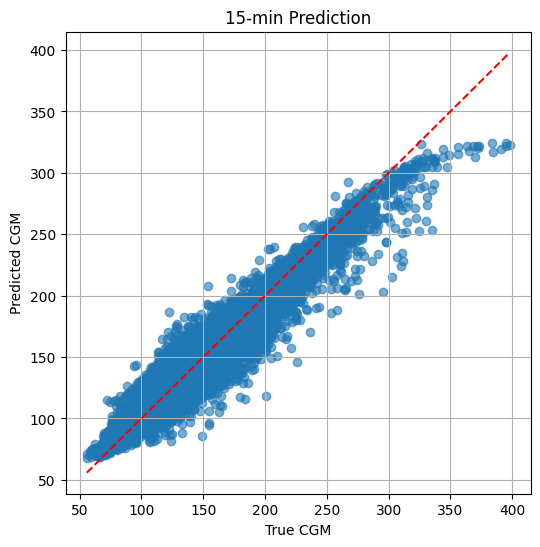

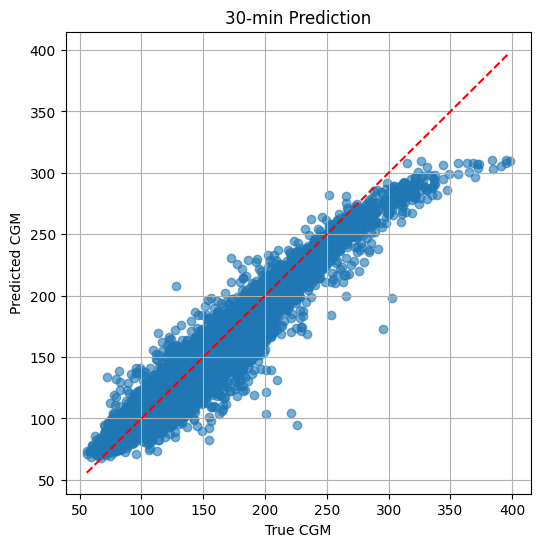

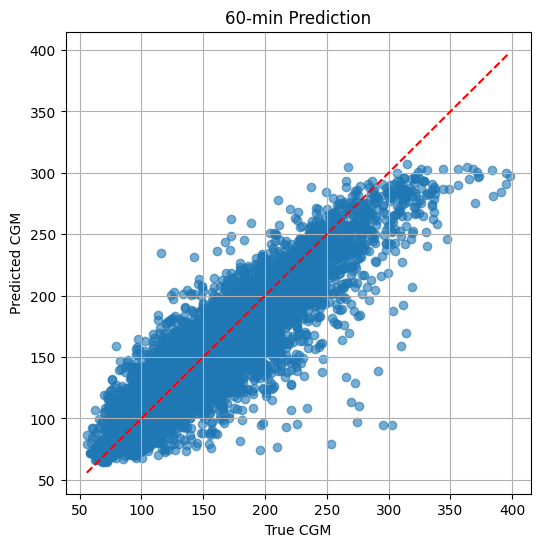

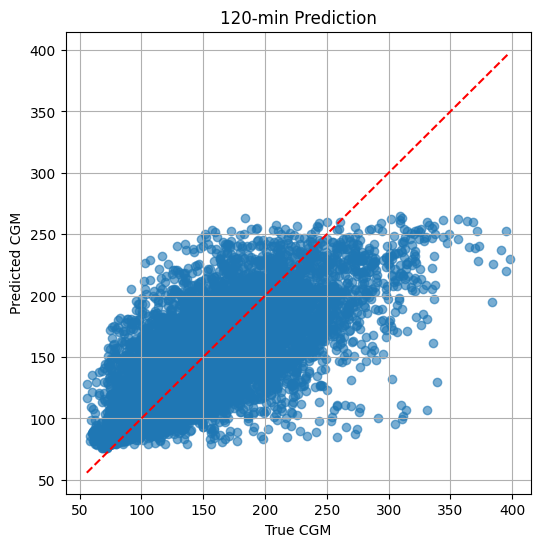

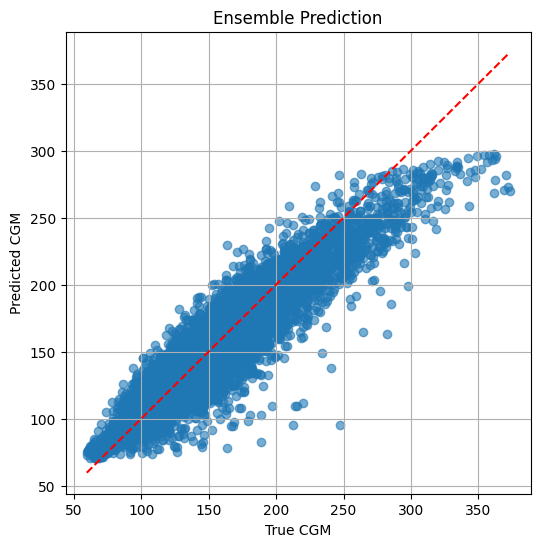


Clarke Grid for 15-min:
Zone A: 93.31%, B: 6.68%, C: 0.02%, D: 0.00%, E: 0.00%
Clarke Grid for 30-min:
Zone A: 93.73%, B: 6.23%, C: 0.04%, D: 0.00%, E: 0.00%
Clarke Grid for 60-min:
Zone A: 88.12%, B: 11.67%, C: 0.18%, D: 0.03%, E: 0.00%
Clarke Grid for 120-min:
Zone A: 71.93%, B: 27.26%, C: 0.72%, D: 0.09%, E: 0.00%
Clarke Grid for Ensemble:
Zone A: 92.11%, B: 7.84%, C: 0.04%, D: 0.00%, E: 0.00%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Load and preprocess data ---
df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Smooth CGM
df['CGM (mg / dl)'] = df['CGM (mg / dl)'].rolling(window=3, min_periods=1).mean()
df = df.dropna(subset=['CGM (mg / dl)'])

# Time features
df['hour'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute
df['dayofweek'] = df['Date'].dt.dayofweek

# Scaling
scaler_cgm = StandardScaler()
df['CGM_scaled'] = scaler_cgm.fit_transform(df[['CGM (mg / dl)']])
scaler_time = StandardScaler()
df[['hour_scaled', 'minute_scaled', 'dayofweek_scaled']] = scaler_time.fit_transform(
    df[['hour', 'minute', 'dayofweek']]
)

# --- Prepare sequences (no dietary intake filtering) ---
time_steps = 8
future_offsets = [1, 2, 4, 8]  # 15, 30, 60, 120 min
features = ['CGM_scaled', 'hour_scaled', 'minute_scaled', 'dayofweek_scaled']

X, y_15, y_30, y_60, y_120 = [], [], [], [], []

for i in range(len(df) - time_steps - max(future_offsets)):
    x_seq = df[features].iloc[i:i + time_steps].values
    X.append(x_seq)
    y_15.append(df['CGM_scaled'].iloc[i + time_steps + 0])
    y_30.append(df['CGM_scaled'].iloc[i + time_steps + 1])
    y_60.append(df['CGM_scaled'].iloc[i + time_steps + 3])
    y_120.append(df['CGM_scaled'].iloc[i + time_steps + 7])

X = np.array(X)
y_15 = np.array(y_15)
y_30 = np.array(y_30)
y_60 = np.array(y_60)
y_120 = np.array(y_120)

# Split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_15, y_test_15 = y_15[:split_idx], y_15[split_idx:]
y_train_30, y_test_30 = y_30[:split_idx], y_30[split_idx:]
y_train_60, y_test_60 = y_60[:split_idx], y_60[split_idx:]
y_train_120, y_test_120 = y_120[:split_idx], y_120[split_idx:]

def build_model():
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train all models
def train_model(X_train, y_train, name):
    model = build_model()
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    mc = ModelCheckpoint(f"{name}_best.keras", save_best_only=True, monitor="val_loss")
    history = model.fit(
        X_train, y_train, epochs=5, batch_size=32,
        validation_split=0.2, callbacks=[es, mc], verbose=1
    )
    return model

model_15 = train_model(X_train, y_train_15, "model_15")
model_30 = train_model(X_train, y_train_30, "model_30")
model_60 = train_model(X_train, y_train_60, "model_60")
model_120 = train_model(X_train, y_train_120, "model_120")

# Predictions and inverse transform
y_pred_15 = scaler_cgm.inverse_transform(model_15.predict(X_test).flatten().reshape(-1, 1)).flatten()
y_pred_30 = scaler_cgm.inverse_transform(model_30.predict(X_test).flatten().reshape(-1, 1)).flatten()
y_pred_60 = scaler_cgm.inverse_transform(model_60.predict(X_test).flatten().reshape(-1, 1)).flatten()
y_pred_120 = scaler_cgm.inverse_transform(model_120.predict(X_test).flatten().reshape(-1, 1)).flatten()

y_true_15 = scaler_cgm.inverse_transform(y_test_15.reshape(-1, 1)).flatten()
y_true_30 = scaler_cgm.inverse_transform(y_test_30.reshape(-1, 1)).flatten()
y_true_60 = scaler_cgm.inverse_transform(y_test_60.reshape(-1, 1)).flatten()
y_true_120 = scaler_cgm.inverse_transform(y_test_120.reshape(-1, 1)).flatten()

# Ensemble
y_pred_ensemble = (y_pred_15 + y_pred_30 + y_pred_60 + y_pred_120) / 4
y_true_ensemble = (y_true_15 + y_true_30 + y_true_60 + y_true_120) / 4

# --- Evaluation ---
def evaluate(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

evaluate(y_true_15, y_pred_15, "15-min")
evaluate(y_true_30, y_pred_30, "30-min")
evaluate(y_true_60, y_pred_60, "60-min")
evaluate(y_true_120, y_pred_120, "120-min")
evaluate(y_true_ensemble, y_pred_ensemble, "Ensemble")

# --- Plotting ---
def plot_predictions(true, pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(true, pred, alpha=0.6)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel("True CGM")
    plt.ylabel("Predicted CGM")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_predictions(y_true_15, y_pred_15, "15-min Prediction")
plot_predictions(y_true_30, y_pred_30, "30-min Prediction")
plot_predictions(y_true_60, y_pred_60, "60-min Prediction")
plot_predictions(y_true_120, y_pred_120, "120-min Prediction")
plot_predictions(y_true_ensemble, y_pred_ensemble, "Ensemble Prediction")

# --- Clarke Error Grid Analysis ---
def clarke_error_grid(true, pred):
    A = B = C = D = E = 0
    for t, p in zip(true, pred):
        if t <= 70:
            if p <= 70:
                A += 1
            elif p <= 180:
                B += 1
            else:
                E += 1
        elif t <= 180:
            if abs(t - p) <= 20:
                A += 1
            elif p <= 70 or p > 240:
                D += 1
            else:
                B += 1
        else:
            if p > 180:
                A += 1
            elif p > 130:
                B += 1
            elif p > 70:
                C += 1
            else:
                E += 1
    total = len(true)
    print(f"Zone A: {A / total * 100:.2f}%, B: {B / total * 100:.2f}%, C: {C / total * 100:.2f}%, D: {D / total * 100:.2f}%, E: {E / total * 100:.2f}%")

print("\nClarke Grid for 15-min:")
clarke_error_grid(y_true_15, y_pred_15)
print("Clarke Grid for 30-min:")
clarke_error_grid(y_true_30, y_pred_30)
print("Clarke Grid for 60-min:")
clarke_error_grid(y_true_60, y_pred_60)
print("Clarke Grid for 120-min:")
clarke_error_grid(y_true_120, y_pred_120)
print("Clarke Grid for Ensemble:")
clarke_error_grid(y_true_ensemble, y_pred_ensemble)


In [ ]:
# --- Actual vs Predicted over time ---
def plot_time_series(true, pred, title):
    plt.figure(figsize=(12, 4))
    plt.plot(true, label="Actual CGM", color='orange')
    plt.plot(pred, label="Predicted CGM", color='lightblue')
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("CGM (mg/dL)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_time_series(y_true_15, y_pred_15, "15-min CGM Prediction (Actual vs Predicted)")
plot_time_series(y_true_30, y_pred_30, "30-min CGM Prediction (Actual vs Predicted)")
plot_time_series(y_true_60, y_pred_60, "60-min CGM Prediction (Actual vs Predicted)")
plot_time_series(y_true_120, y_pred_120, "120-min CGM Prediction (Actual vs Predicted)")
plot_time_series(y_true_ensemble, y_pred_ensemble, "Ensemble CGM Prediction (Actual vs Predicted)")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

print("Performance Metrics:")
rmse_15, mae_15 = print_metrics(y_true_15, y_pred_15, "15-min")
rmse_60, mae_60 = print_metrics(y_true_60, y_pred_60, "60-min")
rmse_120, mae_120 = print_metrics(y_true_120, y_pred_120, "120-min")
